In [5]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

import numpy as np 
import pandas as pd 
import sklearn 
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.ensemble import IsolationForest 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams

rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
# Define labels for the target variable
LABELS = ["Show", "No Show"]


In [6]:
import psutil
print(psutil.__version__)


6.0.0


In [7]:
# Load datasets
no_show = pd.read_csv('no_show.csv')
clinics = pd.read_csv('clinics.csv')
planning_neighborhoods = pd.read_csv('planning_neighborhoods.csv')
no_show_historical = pd.read_csv('no_show_historical.csv')


In [8]:
planning_neighborhoods.drop(columns=['the_geom'], inplace=True)
no_show.drop(['Appointment ID'],axis='columns',inplace=True)
clinics.drop(['name','type','addr1','addr2'],axis='columns',inplace=True)

# Merging datasets
data = pd.merge(no_show, clinics, left_on='Clinic Location', right_on='clinic', how='left')
data = pd.merge(data, planning_neighborhoods, left_on='Neighborhood', right_on='neighborho', how='left')
data = pd.merge(data, no_show_historical, on='Patient ID', how='left')


data.drop(['Patient ID'],axis='columns',inplace=True)

print('data ',data.columns)

data  Index(['no_show_x', 'Gender', 'Age', 'Alcohol Consumption', 'Hypertension',
       'Diabetes', 'Appointment Date', 'Schedule Date', 'Appointment Reason',
       'Clinic Location', 'Specialty', 'Neighborhood', 'clinic', 'lat', 'long',
       'neighborho', 'no_show_y'],
      dtype='object')


In [9]:
data.head()

,no_show_x,Gender,Age,Alcohol Consumption,Hypertension,Diabetes,Appointment Date,Schedule Date,Appointment Reason,Clinic Location,Specialty,Neighborhood,clinic,lat,long,neighborho,no_show_y
0,False,F,43,5/week,False,False,2021-01-14T10:30:00,2020-10-26T00:00:00,CHIROPRACT MANJ 3-4 REGIONS,Mission Bay,Human Performance Center,Russian Hill,Mission Bay,37.764124,-122.456572,Russian Hill,NaN
1,False,F,43,5/week,False,False,2021-01-14T10:30:00,2020-10-26T00:00:00,CHIROPRACT MANJ 3-4 REGIONS,Mission Bay,Human Performance Center,Russian Hill,Mission Bay,37.784882,-122.438723,Russian Hill,NaN
2,False,F,43,5/week,False,False,2021-01-14T10:30:00,2020-10-26T00:00:00,CHIROPRACT MANJ 3-4 REGIONS,Mission Bay,Human Performance Center,Russian Hill,Mission Bay,37.766561,-122.389948,Russian Hill,NaN
3,False,F,37,0/week,False,True,2021-02-17T14:00:00,2021-01-25T00:00:00,OFFICE/OUTPATIENT VISIT EST,Mission Bay,"Endocrine, Diabetes & Pregnancy Program",Ocean View,Mission Bay,37.764124,-122.456572,Ocean View,NaN
4,False,F,37,0/week,False,True,2021-02-17T14:00:00,2021-01-25T00:00:00,OFFICE/OUTPATIENT VISIT EST,Mission Bay,"Endocrine, Diabetes & Pregnancy Program",Ocean View,Mission Bay,37.784882,-122.438723,Ocean View,NaN


In [10]:
# Assuming `data` is your DataFrame and 'column_name' is the column you're interested in
unique_values_count = data['Appointment Reason'].nunique()

print(f"The number of unique values in 'column_name' is: {unique_values_count}")


The number of unique values in 'column_name' is: 3872


In [11]:
data.drop(['Appointment Reason'],axis='columns',inplace=True)

In [12]:
# Combine no_show_x and no_show_y into a single column
if 'no_show_x' in data.columns and 'no_show_y' in data.columns:
    data['target_no_show'] = data['no_show_x'].fillna(data['no_show_y'])
    print('target column updated')
    # Drop the no_show_x and no_show_y columns
    data.drop(columns=['no_show_x', 'no_show_y'], inplace=True)
else:
    raise KeyError("One or both of 'no_show_x' and 'no_show_y' columns not found in the data.")

target column updated


In [13]:
data.head()

,Gender,Age,Alcohol Consumption,Hypertension,Diabetes,Appointment Date,Schedule Date,Clinic Location,Specialty,Neighborhood,clinic,lat,long,neighborho,target_no_show
0,F,43,5/week,False,False,2021-01-14T10:30:00,2020-10-26T00:00:00,Mission Bay,Human Performance Center,Russian Hill,Mission Bay,37.764124,-122.456572,Russian Hill,False
1,F,43,5/week,False,False,2021-01-14T10:30:00,2020-10-26T00:00:00,Mission Bay,Human Performance Center,Russian Hill,Mission Bay,37.784882,-122.438723,Russian Hill,False
2,F,43,5/week,False,False,2021-01-14T10:30:00,2020-10-26T00:00:00,Mission Bay,Human Performance Center,Russian Hill,Mission Bay,37.766561,-122.389948,Russian Hill,False
3,F,37,0/week,False,True,2021-02-17T14:00:00,2021-01-25T00:00:00,Mission Bay,"Endocrine, Diabetes & Pregnancy Program",Ocean View,Mission Bay,37.764124,-122.456572,Ocean View,False
4,F,37,0/week,False,True,2021-02-17T14:00:00,2021-01-25T00:00:00,Mission Bay,"Endocrine, Diabetes & Pregnancy Program",Ocean View,Mission Bay,37.784882,-122.438723,Ocean View,False


In [14]:
# Preprocessing
data['Gender'] = data['Gender'].map({'M': 0, 'F': 1})


In [15]:
# Create age group categories and convert to one-hot encoding
data['age_group'] = pd.cut(data['Age'], bins=[0, 30, 40, 50, 60, 100], labels=['<30', '30-40', '40-50', '50-60', '>60'])
data = pd.get_dummies(data, columns=['age_group'], drop_first=True)

In [16]:
data.drop(['Age'],axis='columns',inplace=True)

In [17]:
# Map 'Alcohol Consumption' to numeric values
mapping_dict = {'0/week': 0, '1/week': 1, '5/week': 2, '10/week': 3, '> 14/week': 4}
data['Alcohol Consumption'] = data['Alcohol Consumption'].map(mapping_dict)

In [18]:
# Convert 'Hypertension' and 'Diabetes' to integer
data['Hypertension'] = data['Hypertension'].astype(int)
data['Diabetes'] = data['Diabetes'].astype(int)

In [19]:
# Convert 'target_no_show' to integer
data['target_no_show'] = data['target_no_show'].astype(int)

In [20]:
# Convert date columns to datetime format and extract features
data['Appointment Date'] = pd.to_datetime(data['Appointment Date'])
data['Schedule Date'] = pd.to_datetime(data['Schedule Date'])
data['appointment_day'] = data['Appointment Date'].dt.day
data['appointment_month'] = data['Appointment Date'].dt.month
data['appointment_year'] = data['Appointment Date'].dt.year
data['appointment_dayofweek'] = data['Appointment Date'].dt.dayofweek
data['schedule_day'] = data['Schedule Date'].dt.day
data['schedule_month'] = data['Schedule Date'].dt.month
data['schedule_year'] = data['Schedule Date'].dt.year
data['schedule_dayofweek'] = data['Schedule Date'].dt.dayofweek
data['days_until_appointment'] = (data['Appointment Date'] - data['Schedule Date']).dt.days

# Drop the original date columns if they are not needed anymore
data.drop(columns=['Appointment Date', 'Schedule Date'], inplace=True)

In [21]:
# Encode categorical variables using one-hot encoding
categorical_columns = ['Clinic Location', 'neighborho']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [22]:
# One-hot encode the 'Appointment Reason', 'Specialty', and 'clinic' columns
data = pd.get_dummies(data, columns=['Specialty', 'clinic'], drop_first=True)

# Drop the 'Neighborhood' column since it's already encoded as neighborho_* columns
data.drop(columns=['Neighborhood'], inplace=True)

# Display the first few rows to verify the changes
data.head()


,Gender,Alcohol Consumption,Hypertension,Diabetes,lat,long,target_no_show,age_group_30-40,age_group_40-50,age_group_50-60,...,Specialty_Vascular Laboratory,Specialty_Vascular and Endovascular Surgery Clinic,Specialty_Vasculitis Clinic,Specialty_Vision Optical Clinic,Specialty_Voice and Swallowing Center,Specialty_Weight Management Program,Specialty_Women's Health Primary Care Clinic,Specialty_Women's Sports Medicine Center,Specialty_Women’s Center for Bladder & Pelvic Health,Specialty_Young Women's Clinic
0,1,2,0,0,37.764124,-122.456572,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,1,2,0,0,37.784882,-122.438723,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,1,2,0,0,37.766561,-122.389948,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,1,0,0,1,37.764124,-122.456572,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,0,0,1,37.784882,-122.438723,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
# Print data types of all columns
print(data.dtypes)


Gender                                                    int64
Alcohol Consumption                                       int64
Hypertension                                              int64
Diabetes                                                  int64
lat                                                     float64
                                                         ...   
Specialty_Weight Management Program                        bool
Specialty_Women's Health Primary Care Clinic               bool
Specialty_Women's Sports Medicine Center                   bool
Specialty_Women’s Center for Bladder & Pelvic Health       bool
Specialty_Young Women's Clinic                             bool
Length: 330, dtype: object


In [24]:
data.info

<bound method DataFrame.info of         Gender  Alcohol Consumption  Hypertension  Diabetes        lat  \
0            1                    2             0         0  37.764124   
1            1                    2             0         0  37.784882   
2            1                    2             0         0  37.766561   
3            1                    0             0         1  37.764124   
4            1                    0             0         1  37.784882   
...        ...                  ...           ...       ...        ...   
132195       1                    1             0         0        NaN   
132196       1                    2             0         0  37.764124   
132197       1                    2             0         0  37.784882   
132198       1                    2             0         0  37.766561   
132199       1                    2             0         0        NaN   

              long  target_no_show  age_group_30-40  age_group_40-50  \
0      

In [25]:
# Create independent and Dependent Features
columns = data.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["target_no_show"]]
# Store the variable we are predicting
target = "target_no_show"

# Define a random state
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)


(132200, 329)
(132200,)


In [26]:
# Remove rows with any missing values
data_cleaned = data.dropna()

# Check if there are still any missing values
data_cleaned.isnull().values.any()


False

/var/folders/0z/lpdq6xc50fb_51rn5s1nddzh0000gn/T/ipykernel_32696/2461647304.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd. value_counts(data[ 'target_no_show'], sort = True)


Text(0, 0.5, 'Frequency')

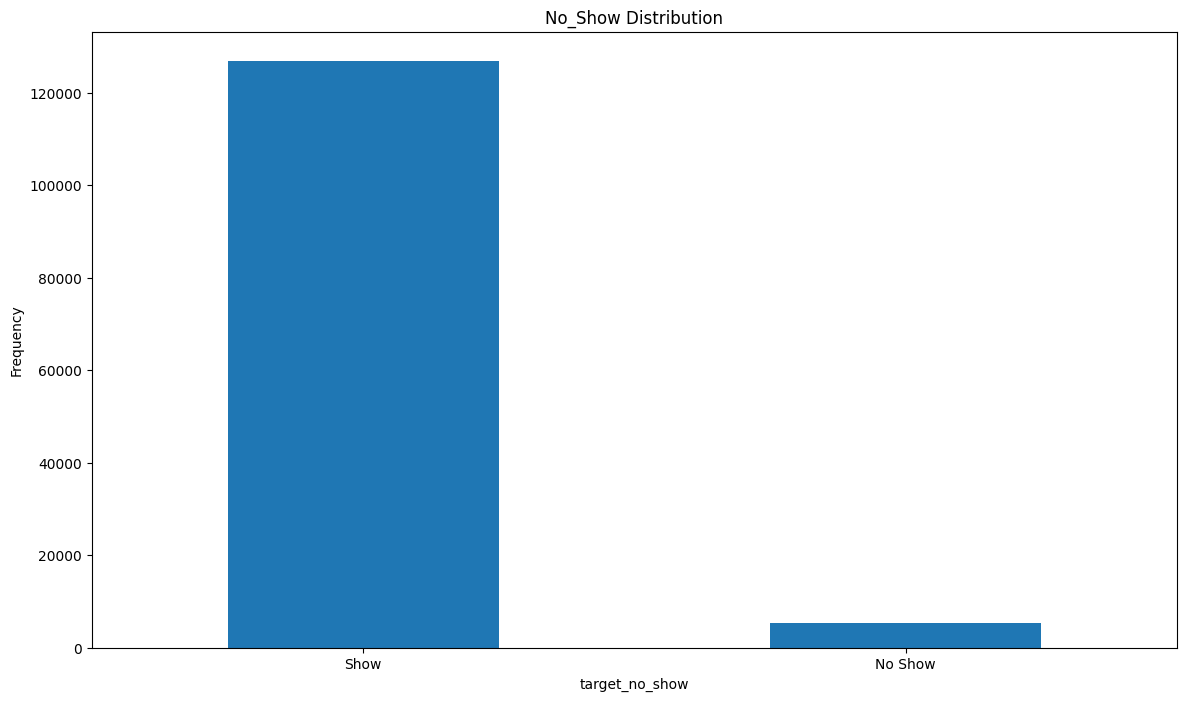

In [27]:
count_classes = pd. value_counts(data[ 'target_no_show'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt. title("No_Show Distribution")
plt. xticks(range(2), LABELS)
plt. xlabel("target_no_show")
plt. ylabel ("Frequency")

In [28]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

In [29]:
# Drop rows with missing values
X_clean = X.dropna()

# Ensure corresponding Y values are also dropped
Y_clean = Y[X_clean.index]

# Apply SMOTETomek
smk = SMOTETomek(random_state=42)
X_res, y_res = smk.fit_resample(X_clean, Y_clean)

# Check the shapes of the resampled data
print(X_res.shape)
print(y_res.shape)


(150192, 329)
(150192,)


In [31]:
from collections import Counter

# Print the original dataset class distribution
print('Original dataset shape: {}'.format(Counter(Y)))

# Print the resampled dataset class distribution
print('Resampled dataset shape: {}'.format(Counter(y_res)))


Original dataset shape: Counter({0: 126850, 1: 5350})
Resampled dataset shape: Counter({0: 75096, 1: 75096})


In [35]:
from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler with a 1:1 sampling strategy
os = RandomOverSampler(sampling_strategy=1.0, random_state=42)

# Fit and resample the data
X_res, y_res = os.fit_resample(X, Y)

# Check the shapes of the resampled data
print(X_res.shape)
print(y_res.shape)



(253700, 329)
(253700,)


In [37]:
from collections import Counter

# Print the original dataset class distribution
print('Original dataset shape: {}'.format(Counter(Y)))

# Print the resampled dataset class distribution
print('Resampled dataset shape: {}'.format(Counter(y_res)))


Original dataset shape: Counter({0: 126850, 1: 5350})
Resampled dataset shape: Counter({0: 126850, 1: 126850})


In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 150),  # Number of trees in the forest
    'max_depth': randint(5, 30),       # Maximum depth of the tree
    'min_samples_split': randint(2, 10), # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 10),  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]          # Whether bootstrap samples are used when building trees
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=RANDOM_SEED)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, 
    n_iter=100,  # Number of parameter settings to sample
    cv=5,        # Number of cross-validation folds
    verbose=2,   # Verbosity level
    n_jobs=-1,   # Use all available cores
    random_state=RANDOM_SEED
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:\n", random_search.best_params_)
print("Best Score:\n", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=24, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time= 1.4min
[CV] END bootstrap=True, max_depth=24, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time= 1.4min
[CV] END bootstrap=True, max_depth=24, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time= 1.4min
[CV] END bootstrap=True, max_depth=24, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time= 1.4min
[CV] END bootstrap=True, max_depth=24, min_samples_leaf=8, min_samples_split=6, n_estimators=70; total time= 1.4min
[CV] END bootstrap=True, max_depth=23, min_samples_leaf=7, min_samples_split=4, n_estimators=124; total time= 2.3min
[CV] END bootstrap=True, max_depth=23, min_samples_leaf=7, min_samples_split=4, n_estimators=124; total time= 2.3min
[CV] END bootstrap=True, max_depth=23, min_samples_leaf=7, min_samples_split=4, n_estimators=124; total time= 2.3min
[CV] E

In [4]:
from sklearn.metrics import classification_report

# Initialize the classifier with the best parameters
best_rf = random_search.best_estimator_

# Fit the model on the training data
best_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = best_rf.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=LABELS)
print("Classification Report:\n", report)


NameError: name 'random_search' is not defined

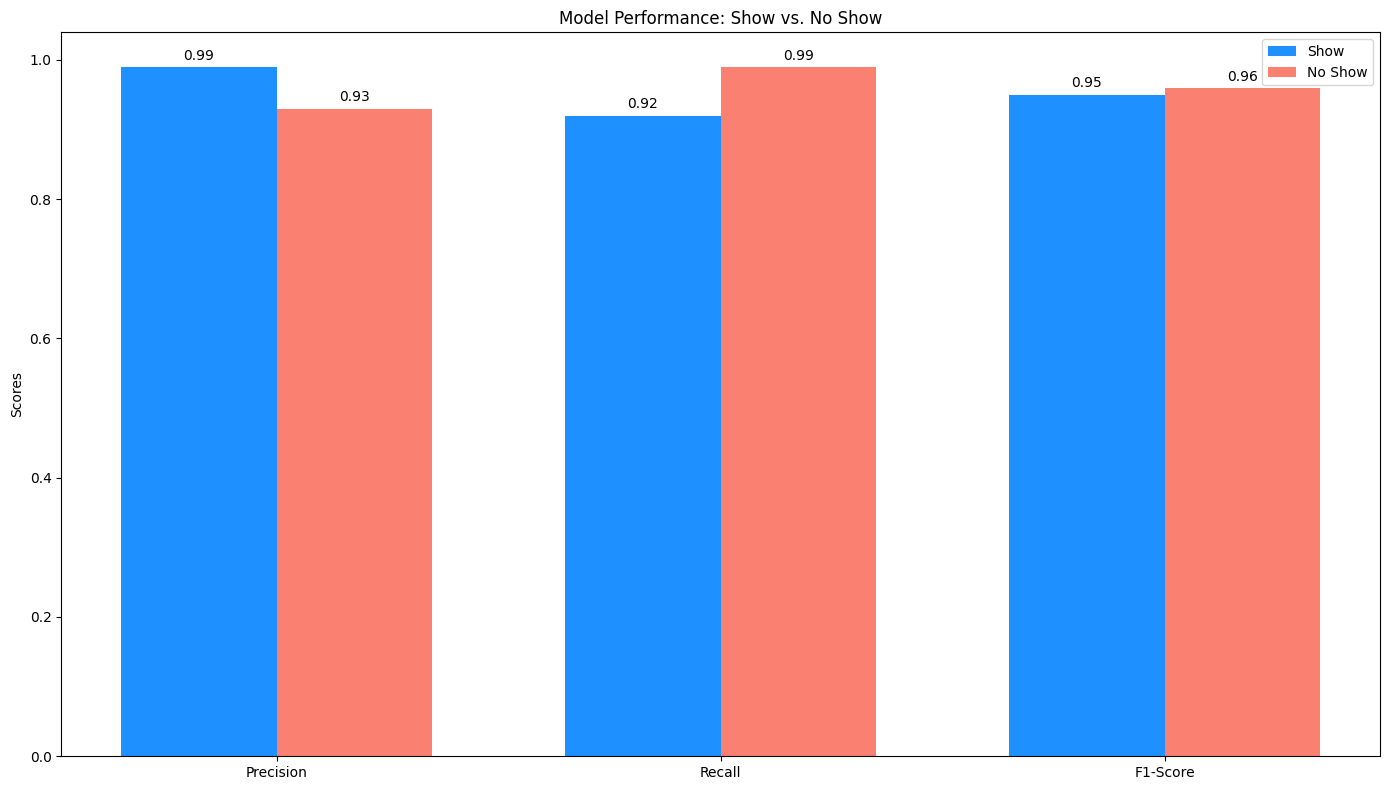

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data from classification report
categories = ['Precision', 'Recall', 'F1-Score']
show_scores = [0.99, 0.92, 0.95]  # Example scores for 'Show'
no_show_scores = [0.93, 0.99, 0.96]  # Example scores for 'No Show'

x = np.arange(len(categories))  # label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

# Bars for 'Show'
rects1 = ax.bar(x - width/2, show_scores, width, label='Show', color='dodgerblue')

# Bars for 'No Show'
rects2 = ax.bar(x + width/2, no_show_scores, width, label='No Show', color='salmon')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance: Show vs. No Show')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add data labels above bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

# Display the plot
plt.tight_layout()
plt.show()


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Assuming you have y_test and y_pred from your model
report = classification_report(y_test, y_pred, target_names=LABELS, output_dict=True)

# Extracting precision and recall
precision = [report['Show']['precision'], report['No Show']['precision']]
recall = [report['Show']['recall'], report['No Show']['recall']]

# Creating a DataFrame for better visualization
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall
}, index=LABELS)

# Plotting the metrics
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Precision and Recall for Show and No Show')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1)  # Precision and recall are between 0 and 1
plt.xticks(rotation=0)
plt.show()

# Optional: Displaying the confusion matrix for better understanding
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=LABELS)
plt.title('Confusion Matrix')
plt.show()


NameError: name 'y_test' is not defined